In [1]:
from typing import Annotated, List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
import pandas as pd
from io import StringIO
import io
import contextlib
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import re

from dotenv import load_dotenv
import os

load_dotenv()
openai_api_key = os.getenv("OPEN_API_KEY")

In [2]:
# --- 상태 정의 ---
class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    df: pd.DataFrame
    code: str
    result: str

# --- LLM 설정 ---
llm = ChatOpenAI(model="gpt-4o", openai_api_key=openai_api_key)

In [3]:
# ──── 프롬프트 상수 분리 ──────────────────────────────
CODE_PROMPT_TEMPLATE = """
당신은 데이터 분석용 AI 코드를 생성하는 도우미입니다.
아래는 데이터 일부입니다:

{df_head}

사용자의 요청:
"{question}"

다음 조건에 따라 **순수한 Python 코드만** 작성하세요:
- `df`는 이미 존재하는 pandas DataFrame입니다.
- 필요한 경우 `matplotlib.pyplot`은 `plt`, `seaborn`은 `sns`로 import 되었다고 가정하세요
- **결과는 반드시 print() 함수로 출력하세요. 표현식만 사용하지 말고 출력 결과가 생기도록 하세요.**
- **설명, 주석, 출력 없이** Python 코드만 출력하세요.
- **반드시 코드 블록 없이** 순수한 코드만 주세요.
"""

SUMMARY_PROMPT_TEMPLATE = """
당신은 데이터 분석 보고서를 요약하는 도우미입니다.

사용자의 질문:
\"{question}\"

아래는 pandas 코드 실행 결과입니다:
\"\"\"\n{result}\n\"\"\"

이 결과를 바탕으로, **사용자의 질문에 정확하게 수치 기반으로** 응답하세요.
- 코드나 설명을 포함하지 마세요.
- 예: \"Height 컬럼에는 결측치가 1개 있습니다.\"
- 출력 결과에서 수치를 직접 찾아 간결하게 요약하세요.
"""

In [4]:
def clean_code(raw_code: str) -> str:
    # ``` 또는 ```python 으로 감싼 코드 제거
    return re.sub(r"```(?:python)?|```", "", raw_code).strip()

In [5]:
# ──── 코드 생성 노드 ────────────────────────────────
def generate_code(state: AgentState) -> AgentState:
    question   = state["messages"][-1].content
    df_sample  = state["df"].head().to_csv(index=False)

    prompt = CODE_PROMPT_TEMPLATE.format(
        df_head=df_sample,
        question=question
    )

    raw_code = llm.invoke(prompt).content
    code = clean_code(raw_code)
    return {**state, "code": code}

In [6]:
# --- 코드 실행 노드 ---
def execute_code(state: AgentState) -> AgentState:
    code = state["code"]
    df = state["df"]

    print("\n📍code")
    print(code)
    print()

    local_vars = {
        "df": df,
        "plt": __import__("matplotlib.pyplot"),
        "sns": __import__("seaborn")
    }

    f = io.StringIO()
    with contextlib.redirect_stdout(f):  # 🔥 print 결과를 f에 저장
        try:
            exec(code, {}, local_vars)
        except Exception as e:
            return {**state, "result": f"❌ 실행 오류: {e}"}

    output = f.getvalue().strip()
    print("📍output:")
    print(output)
    return {**state, "result": output}

In [7]:
# ──── 결과 요약 노드 ────────────────────────────────
def summarize_result(state: AgentState) -> AgentState:
    question = state["messages"][-1].content
    result   = state["result"]

    prompt = SUMMARY_PROMPT_TEMPLATE.format(
        question=question,
        result=result
    )

    summary = llm.invoke(prompt).content.strip()
    return {**state, "result": summary}

In [8]:
# --- 응답 노드 ---
def return_result(state: AgentState) -> AgentState:
    print("\n📢 사용자 질문에 대한 답변:")
    print(state["result"])
    print()
    return state

In [9]:
# --- 그래프 구성 ---
graph = StateGraph(AgentState)
graph.set_entry_point("generate_code")

graph.add_node("generate_code", generate_code)
graph.add_node("execute_code", execute_code)
graph.add_node("summarize_result", summarize_result)
graph.add_node("return_result", return_result)

graph.add_edge("generate_code", "execute_code")
graph.add_edge("execute_code", "summarize_result")
graph.add_edge("summarize_result", "return_result")
graph.add_edge("return_result", END)
agent = graph.compile()

📊 CSV 분석 에이전트 실행


📂 파일 경로 입력 (예: sample.csv):  CB_BM.csv
❓ 질문을 입력하세요 (종료하려면 'exit'):  각 컬럼의 상관관계 히트맵 그려줘



📍code
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df.replace(' ', np.nan, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.iloc[:, 6:] = df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')

corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()
print(corr)



<string>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



📢 사용자 질문에 대한 답변:
데이터셋에 날짜 형식의 문자열이 포함되어 있어 상관관계 계산을 수행할 수 없습니다.



❓ 질문을 입력하세요 (종료하려면 'exit'):  S1 S2 S3 S4 컬럼의 상관관계 히트맵 그려줘. 우측의 값 범주가 어떤 것인지 추가해서 plot (ex correlation) 해줘


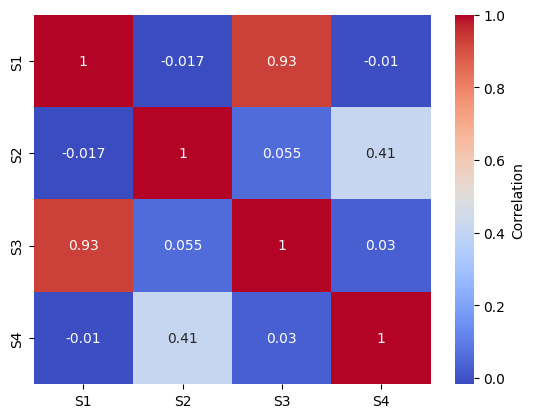


📍code
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df[['S1', 'S2', 'S3', 'S4']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.show()
print(correlation_matrix)

📍output:
S1        S2        S3        S4
S1  1.000000 -0.016883  0.930266 -0.010055
S2 -0.016883  1.000000  0.055145  0.408520
S3  0.930266  0.055145  1.000000  0.030351
S4 -0.010055  0.408520  0.030351  1.000000

📢 사용자 질문에 대한 답변:
- S1과 S2의 상관관계는 -0.016883입니다.
- S1과 S3의 상관관계는 0.930266입니다.
- S1과 S4의 상관관계는 -0.010055입니다.
- S2와 S3의 상관관계는 0.055145입니다.
- S2와 S4의 상관관계는 0.408520입니다.
- S3과 S4의 상관관계는 0.030351입니다.



❓ 질문을 입력하세요 (종료하려면 'exit'):  exit


👋 종료합니다.


In [10]:
# --- 실행 예시 ---
if __name__ == "__main__":
    print("📊 CSV 분석 에이전트 실행")
    csv_path = input("📂 파일 경로 입력 (예: sample.csv): ").strip()

    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"❌ CSV 불러오기 실패: {e}")
        exit(1)

    messages = []

    while True:
        question = input("❓ 질문을 입력하세요 (종료하려면 'exit'): ").strip()
        if question.lower() in {"exit", "종료", "quit"}:
            print("👋 종료합니다.")
            break

        messages.append(HumanMessage(content=question))

        inputs = {
            "messages": messages,
            "df": df,
            "code": "",
            "result": ""
        }

        result_state = agent.invoke(inputs)
        # 최신 응답을 메시지로 추가
        messages.append(BaseMessage(content=result_state["result"], type="ai"))

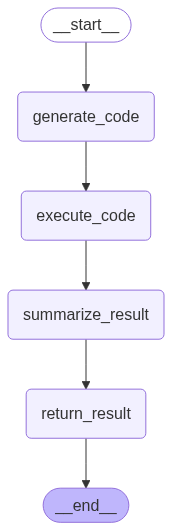

In [4]:
# 그래프 이미지화 코드
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))